# Trajectory Recommendation using POI Ranking and Active Learning

## 1. Overview

1. Rank POIs using rankSVM
1. Recommend a set of POIs given (start, end, length)

In [1]:
% matplotlib inline

import os, re, sys, time, pickle, tempfile
import math, random, itertools, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sop
from joblib import Parallel, delayed

In [2]:
random.seed(987654321) # control random choice when splitting training/testing set
np.random.seed(987654321)
ranksvm_dir = '$HOME/work/ranksvm'

In [3]:
data_dir = 'data/data-ijcai15'
#fvisit = os.path.join(data_dir, 'userVisits-Osak.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Osak.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Glas.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Glas.csv')
#fvisit = os.path.join(data_dir, 'userVisits-Edin.csv')
#fcoord = os.path.join(data_dir, 'photoCoords-Edin.csv')
fvisit = os.path.join(data_dir, 'userVisits-Toro.csv')
fcoord = os.path.join(data_dir, 'photoCoords-Toro.csv')

In [4]:
suffix = fvisit.split('-')[-1].split('.')[0]
fseqpart = os.path.join(data_dir, 'seqPart-' + suffix + '.pkl')

In [5]:
visits = pd.read_csv(fvisit, sep=';')
coords = pd.read_csv(fcoord, sep=';')
assert(visits.shape[0] == coords.shape[0])
traj = pd.merge(visits, coords, on='photoID') # merge data frames according to column 'photoID'
#traj.head()

In [6]:
num_photo = traj['photoID'].unique().shape[0]
num_user = traj['userID'].unique().shape[0]
num_poi = traj['poiID'].unique().shape[0]
num_seq = traj['seqID'].unique().shape[0]
pd.DataFrame({'#photo': num_photo, '#user': num_user, '#poi': num_poi, '#seq': num_seq, \
              '#photo/user': num_photo/num_user, '#seq/user': num_seq/num_user}, index=[str(suffix)])

,#photo,#photo/user,#poi,#seq,#seq/user,#user
Toro,39419,28.257348,29,6057,4.341935,1395


## 2.1 Compute POI Information

Compute POI (Longitude, Latitude) as the average coordinates of the assigned photos.

In [7]:
poi_coords = traj[['poiID', 'photoLon', 'photoLat']].groupby('poiID').mean()
poi_coords.reset_index(inplace=True)
poi_coords.rename(columns={'photoLon':'poiLon', 'photoLat':'poiLat'}, inplace=True)

Extract POI category and visiting frequency.

In [8]:
poi_catfreq = traj[['poiID', 'poiTheme', 'poiFreq']].groupby('poiID').first()
poi_catfreq.reset_index(inplace=True)

In [9]:
poi_all = pd.merge(poi_catfreq, poi_coords, on='poiID')
poi_all.set_index('poiID', inplace=True)
poi_all.head()
#poi_all.to_csv(fpoi, index=True)

,poiTheme,poiFreq,poiLon,poiLat
poiID,,,,
1,Sport,3506,-79.379243,43.643183
2,Sport,609,-79.418634,43.632772
3,Sport,688,-79.380045,43.662175
4,Sport,3056,-79.389290,43.641297
6,Cultural,986,-79.392396,43.653662


## 2.2 Construct Travelling Sequences

In [10]:
seq_all = traj[['userID', 'seqID', 'poiID', 'dateTaken']].copy().groupby(['userID', 'seqID', 'poiID'])\
          .agg([np.min, np.max, np.size])
seq_all.columns = seq_all.columns.droplevel()
seq_all.reset_index(inplace=True)
seq_all.rename(columns={'amin':'arrivalTime', 'amax':'departureTime', 'size':'#photo'}, inplace=True)
seq_all['poiDuration(sec)'] = seq_all['departureTime'] - seq_all['arrivalTime']
seq_all.head()

,userID,seqID,poiID,arrivalTime,departureTime,#photo,poiDuration(sec)
0,10007579@N00,1,30,1346844688,1346844688,1,0
1,10012675@N05,2,6,1142731848,1142732445,4,597
2,10012675@N05,3,6,1142916492,1142916492,1,0
3,10012675@N05,4,13,1319327174,1319332848,9,5674
4,10014440@N06,5,24,1196128621,1196128878,3,257


In [11]:
seq_stats = seq_all[['userID', 'seqID', 'poiID']].copy().groupby(['userID', 'seqID']).agg(np.size)
seq_stats.reset_index(inplace=True)
seq_stats.rename(columns={'poiID':'seqLen'}, inplace=True)
seq_stats.set_index('seqID', inplace=True)
seq_stats.head()

,userID,seqLen
seqID,,
1,10007579@N00,1
2,10012675@N05,1
3,10012675@N05,1
4,10012675@N05,1
5,10014440@N06,1


In [12]:
def extract_seq(seqid, seq_all):
    seqi = seq_all[seq_all['seqID'] == seqid].copy()
    seqi.sort_values(by=['arrivalTime'], ascending=True, inplace=True)
    return seqi['poiID'].tolist()

In [13]:
def calc_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby('poiID').agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info.set_index('poiID', inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info.index, 'poiTheme']
    poi_info['poiLon'] = poi_all.loc[poi_info.index, 'poiLon']
    poi_info['poiLat'] = poi_all.loc[poi_info.index, 'poiLat']
    return poi_info.copy()

In [14]:
def calc_userwise_poi_info(seqid_set, seq_all, poi_all):
    poi_info = seq_all[seq_all['seqID'].isin(seqid_set)][['poiID', 'userID', 'poiDuration(sec)']].copy()
    poi_info = poi_info.groupby(['userID', 'poiID']).agg([np.mean, np.size])
    poi_info.columns = poi_info.columns.droplevel()
    poi_info.reset_index(inplace=True)
    poi_info.rename(columns={'mean':'avgDuration(sec)', 'size':'popularity'}, inplace=True)
    poi_info['poiTheme'] = poi_all.loc[poi_info['poiID'], 'poiTheme'].get_values()
    poi_info['poiLon'] = poi_all.loc[poi_info['poiID'], 'poiLon'].get_values()
    poi_info['poiLat'] = poi_all.loc[poi_info['poiID'], 'poiLat'].get_values()
    poi_info.set_index(['userID', 'poiID'], inplace=True)
    return poi_info.copy()

## 2.3 Train vs. Query vs. Test Data

Split sequences into training set and test data.

In [15]:
#train_percent = 0.3
query_percent = 0.5
seqid_set_train0 = []
seqid_set_query0 = []
seqid_set_test0 = []
query_id_dict = dict()

Remove duplicate trajectories (i.e. same trajectory for different users.

In [16]:
seq_stats = seq_stats[seq_stats['seqLen'] > 2]
seq_stats = seq_stats[seq_stats['seqLen'] < 10]
seqid_set_ = seq_stats.index.tolist()
seq_dict = dict()
for seqid in seqid_set_:
    seq = extract_seq(seqid, seq_all)
    key = str(seq)
    if key in seq_dict: seq_dict[key].append(seqid)
    else: seq_dict[key] = [seqid]

In [17]:
len(seqid_set_)

333

In [18]:
seqid_set_exp = [seq_dict[x][0] for x in sorted(seq_dict.keys())]

~~Define a *query* (in IR terminology) using tuple (start POI, end POI, #POI)user ID.~~

In [19]:
#seqs_exp = [extract_seq(seqid, seq_all) for seqid in seqid_set_exp]
#keys = [(seq[0], seq[-1], len(seq)) for seq in seqs_exp]
keys = [seq_stats.loc[seqid, 'userID'] for seqid in seqid_set_exp]
cnt = 0
for key in keys:
    if key not in query_id_dict:
        query_id_dict[key] = cnt
        cnt += 1

Random split trajectories for training, querying and testing.

In [20]:
np.random.shuffle(seqid_set_exp)
#ntrain = int(train_percent * len(seqid_set_exp))
ntrain = 1
nquery = int(query_percent * len(seqid_set_exp))
seqid_set_train0 = sorted(list(seqid_set_exp[:ntrain]))
seqid_set_query0 = sorted(list(seqid_set_exp[ntrain:ntrain+nquery]))
seqid_set_test0 = sorted(list(seqid_set_exp[ntrain+nquery:]))

In [21]:
print('#seq in total:', len(seqid_set_exp))
print('#seq for training:', ntrain, seqid_set_train0)
print('#seq for querying:', nquery)
print('#seq for testing:', len(seqid_set_exp)-ntrain-nquery)

#seq in total: 290
#seq for training: 1 [3090]
#seq for querying: 145
#seq for testing: 144


### Training Data

Training data are generated as follows:
1. ~~each input tuple (\text{startPOI}, \text{endPOI}, \text{#POI}) form a `query` (in IR terminology).~~
1. the label of a specific POI is the number of presence ~~of that POI in a specific `query`.~~
1. ~~the label of all absence POIs in a specific `query` got a label 0.~~ ~~unobserved for absence POIs in a specific `query`.~~

### Test Data

Test data are generated the same way as training data, ~~except that the labels of testing data (unknown) could be arbitrary values as suggested in [libsvm FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f431).~~
Yes, but the reported accuracy (by `svm-predict` command) is calculated based on these values, so just use the same procedure as that to generate training data.

In [22]:
def gen_data_df(seqid_set, seq_all, seq_stats, poi_info, query_id_dict):
    columns = ['label', 'queryId', 'popularity', 'avgDuration(sec)']
    poi_list = poi_info.index
    train_df = pd.DataFrame(data=np.zeros((len(poi_list), len(columns)), dtype=np.float), \
                            index=poi_list, columns=columns)
    train_df['popularity'] = poi_info.loc[train_df.index, 'popularity']
    train_df['avgDuration(sec)'] = poi_info.loc[train_df.index, 'avgDuration(sec)']
    for seqid in sorted(set(seqid_set)):
        seq = extract_seq(seqid, seq_all)
        #key = (seq[0], seq[-1], len(seq))
        key = seq_stats.loc[seqid, 'userID']
        qid = query_id_dict[key]
        for poi in seq:
            train_df.loc[poi, 'queryId'] = qid # possible rewritten
            train_df.loc[poi, 'label'] += 1
    return train_df

Use (user, poi) pair features.

In [23]:
def gen_data_df1(seqid_set, seq_all, seq_stats, poi_info, query_id_dict): 
    seqid_list = list(seqid_set)
    seqs = [extract_seq(seqid, seq_all) for seqid in seqid_list]
    poi_qid_pairs = set()
    for idx in range(len(seqid_list)):
        seqid = seqid_list[idx]
        seq = seqs[idx]
        userId = seq_stats.loc[seqid, 'userID']
        qid = query_id_dict[userId]
        for poi in seq:
            poi_qid_pairs.add((poi, qid))
    
    train_df = pd.DataFrame(data=np.array(list(poi_qid_pairs), dtype=np.float), columns=['poiID', 'queryID'])
    train_df['label'] = 0
    train_df['popularity'] = 0
    train_df['avgDuration(sec)'] = 0
    train_df.set_index(['poiID', 'queryID'], inplace=True)
    
    for idx in range(len(seqid_list)):
        seqid = seqid_list[idx]
        seq = seqs[idx]
        userId = seq_stats.loc[seqid, 'userID']
        qid = query_id_dict[userId]
        for poi in seq:
            train_df.loc[(poi, qid), 'label'] += 1
            train_df.loc[(poi, qid), 'popularity'] = poi_info.loc[poi, 'popularity']
            train_df.loc[(poi, qid), 'avgDuration(sec)'] = poi_info.loc[poi, 'avgDuration(sec)']
    train_df.reset_index(inplace=True)
    return train_df

Use user-wise features, i.e., user-wise POI popularity and POI visit duration.

In [24]:
def gen_userwise_data_df(seqid_set, seq_all, seq_stats, userwise_poi_info, query_id_dict):
    seqid_list = list(seqid_set)
    seqs = [extract_seq(seqid, seq_all) for seqid in seqid_list]
    poi_qid_pairs = set()
    for idx in range(len(seqid_list)):
        seqid = seqid_list[idx]
        seq = seqs[idx]
        userId = seq_stats.loc[seqid, 'userID']
        qid = query_id_dict[userId]
        for poi in seq:
            poi_qid_pairs.add((poi, qid))

    train_df = pd.DataFrame(data=np.array(list(poi_qid_pairs), dtype=np.float), columns=['poiID', 'queryID'])
    train_df['label'] = 0
    train_df['popularity'] = 0
    train_df['avgDuration(sec)'] = 0
    train_df.set_index(['poiID', 'queryID'], inplace=True)

    for idx in range(len(seqid_list)):
        seqid = seqid_list[idx]
        seq = seqs[idx]
        userId = seq_stats.loc[seqid, 'userID']
        qid = query_id_dict[userId]
        for poi in seq:
            train_df.loc[(poi, qid), 'label'] += 1
            train_df.loc[(poi, qid), 'popularity'] = userwise_poi_info.loc[(userId, poi), 'popularity']
            train_df.loc[(poi, qid), 'avgDuration(sec)'] = userwise_poi_info.loc[(userId, poi), 'avgDuration(sec)']
    train_df.reset_index(inplace=True)
    return train_df

In [25]:
#pinfo_ = calc_poi_info(seqid_set_query0, seq_all, poi_all)
#gen_data_df(seqid_set_query0, seq_all, seq_stats, pinfo_, query_id_dict)
#pinfo_ = calc_userwise_poi_info(seqid_set_query0, seq_all, poi_all)
#gen_userwise_data_df(seqid_set_query0, seq_all, seq_stats, pinfo_, query_id_dict)

Data points of trajectories for training and querying.

In [26]:
poi_info_ = calc_poi_info(seqid_set_train0 + seqid_set_query0, seq_all, poi_all)
df_ = gen_data_df(seqid_set_train0 + seqid_set_query0, seq_all, seq_stats, poi_info_, query_id_dict)
#df_.to_csv('train_and_query.csv', index=False)

In [27]:
df_.head()

,label,queryId,popularity,avgDuration(sec)
poiID,,,,
1,12,12,12,1581.333333
2,1,45,1,40.000000
3,11,103,11,512.181818
4,11,0,11,2626.090909
6,27,12,27,3152.185185


Scatter plot of POI popularity and POI average visit duration.

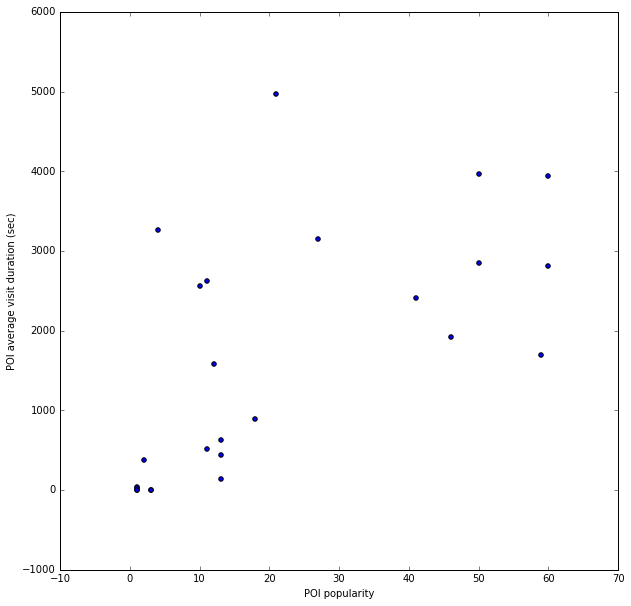

In [28]:
plt.figure(figsize=[10, 10])
plt.scatter(df_['popularity'], df_['avgDuration(sec)'])
plt.xlabel('POI popularity')
plt.ylabel('POI average visit duration (sec)')

In [29]:
#cat_ = poi_info_['poiTheme'].unique()
#cat_map = {v:i for i, v in enumerate(sorted(cat_))}
#print(cat_map)

Pearson correlation coefficient between POI *label* (i.e. the #visits of a user) and *popularity*.

In [30]:
import scipy.stats
scipy.stats.pearsonr(df_['label'], df_['popularity'])

(1.0, 0.0)

## 2.4 Ranking POIs using rankSVM

RankSVM implementation in libsvm can be downloaded [here (zip file)](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/ranksvm/libsvm-ranksvm-3.20.zip), please read `README.ranksvm` in the zip file for installation instructions.

Below is a python wrapper of the `svm-train` and `svm-predict` commands of rankSVM.

In [31]:
# python wrapper of rankSVM
class RankSVM:
    def __init__(self, bin_dir, debug=False):
        dir_ = !echo $bin_dir  # deal with environmental variables in path
        assert(os.path.exists(dir_[0]))
        self.bin_dir = dir_[0]
        assert(isinstance(debug, bool))
        self.debug = debug
        
        # create named tmp files for model and feature scaling parameters
        self.fmodel = None
        self.fscale = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fmodel = fd.name
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            self.fscale = fd.name
        
        if self.debug:
            print('model file:', self.fmodel)
            print('feature scaling parameter file:', self.fscale)
    
    
    def __del__(self):
        # remove tmp files
        if self.fmodel is not None and os.path.exists(self.fmodel):
            os.unlink(self.fmodel)
        if self.fscale is not None and os.path.exists(self.fscale):
            os.unlink(self.fscale)
    
    
    def train(self, train_df, cost=1):
        # cost is parameter C in SVM
        # write train data to file
        ftrain = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain = fd.name
            for idx in train_df.index:
                line = str(train_df.loc[idx, 'label'])
                #line += ' qid:' + str(int(train_df.loc[idx, 'queryId']))
                line += ' 1:' + str(train_df.loc[idx, 'popularity'])
                line += ' 2:' + str(train_df.loc[idx, 'avgDuration(sec)'])
                fd.write(line + '\n')
        
        # feature scaling
        ftrain_scaled = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftrain_scaled = fd.name
        result = !$self.bin_dir/svm-scale -s $self.fscale $ftrain > $ftrain_scaled
        
        if self.debug:
            print('train data file:', ftrain)
            print('feature scaled train data file:', ftrain_scaled)
        
        # train rank svm and generate model file, if the model file exists, rewrite it
        #n_cv = 10  # parameter k for k-fold cross-validation, NO model file will be generated in CV mode
        #result = !$self.bin_dir/svm-train -c $cost -v $n_cv $ftrain $self.fmodel
        result = !$self.bin_dir/svm-train -c $cost $ftrain_scaled $self.fmodel
        if self.debug:
            print('Training finished.')
            for i in range(len(result)): print(result[i])

        # remove train data file
        os.unlink(ftrain)
        os.unlink(ftrain_scaled)
        
    
    def predict(self, test_df):
        if self.fmodel is None or not os.path.exists(self.fmodel):
            print('Model should be trained before predicting')
            return
        
        # write test data to file
        ftest = None
        with tempfile.NamedTemporaryFile(mode='w+t', delete=False) as fd: 
            ftest = fd.name
            for idx in test_df.index:
                line = str(test_df.loc[idx, 'label'])
                #line += ' qid:' + str(int(test_df.loc[idx, 'queryId']))
                line += ' 1:' + str(test_df.loc[idx, 'popularity'])
                line += ' 2:' + str(test_df.loc[idx, 'avgDuration(sec)'])
                fd.write(line + '\n')
                
        # feature scaling
        ftest_scaled = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            ftest_scaled = fd.name
        result = !$self.bin_dir/svm-scale -r $self.fscale $ftest > $ftest_scaled
            
        # generate prediction file
        fpredict = None
        with tempfile.NamedTemporaryFile(delete=False) as fd: 
            fpredict = fd.name
            
        if self.debug:
            print('test data file:', ftest)
            print('feature scaled test data file:', ftest_scaled)
            print('predict result file:', fpredict)
        
            
        # predict using trained model and write prediction to file
        result = !$self.bin_dir/svm-predict $ftest_scaled $self.fmodel $fpredict
        if self.debug:
            print('Predict result: %-30s  %s' % (result[0], result[1]))
        
        # generate prediction DataFrame from prediction file
        poi_rank_df = pd.read_csv(fpredict, header=None)
        poi_rank_df.rename(columns={0:'rank'}, inplace=True)
        poi_rank_df['poiID'] = test_df.index
        poi_rank_df.set_index('poiID', inplace=True)
        
        # remove test file and prediction file
        os.unlink(ftest)
        os.unlink(ftest_scaled)
        os.unlink(fpredict)
        
        return poi_rank_df

# 3. Recommend Trajectory

In [32]:
def enum_seq(poi_list, startPOI, endPOI, nPOI):
    """
    Enumerate all possible subset of poi_list without startPOI and endPOI,
    The size of subset is nPOI-2
    """
    assert(nPOI > 2)
    assert(nPOI < len(poi_list))
    tuples = itertools.combinations([p for p in poi_list if p not in {startPOI, endPOI}], nPOI-2)
    return [[startPOI] + list(x) + [endPOI] for x in tuples]

In [33]:
def calc_F1score(seq_act, seq_rec):
    assert(len(seq_act) > 0)
    assert(len(seq_rec) > 0)

    act_set = set(seq_act)
    rec_set = set(seq_rec)
    intersect = act_set & rec_set
    
    recall = len(intersect) / len(act_set)
    precision = len(intersect) / len(rec_set)
    F1score = 2. * precision * recall / (precision + recall)
  
    #return precision, recall, F1score
    return F1score

In [34]:
def evaluate(seqid_set_test, seq_all, poi_all, poi_rank_df, query_id_dict, debug=False):
    assert(isinstance(debug, bool))
    
    F1scores = []
    pois = poi_rank_df.index
    ranks = poi_rank_df['rank'].get_values()
    ranked_poi = pois[ranks.argsort()][::-1]  # highest rank --> lowest rank 
    
    # randomly put POIs that haven't seen before at the bottom of ranking
    unseen_poi = sorted(list(set(poi_all.index) - set(pois)))
    np.random.shuffle(unseen_poi)
    ranked_poi = list(ranked_poi) + unseen_poi
    
    #seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_test]
    #F1scores = Parallel(n_jobs=-2)\
    #           (delayed(calc_F1score)\
    #            (x, [x[0]] + [p for p in ranked_poi if p not in {x[0], x[-1]}][:len(x)-2] + [x[-1]]) for x in seqs)
    
    for seqid in seqid_set_test:
        seq = extract_seq(seqid, seq_all)
        poi_rec = [p for p in ranked_poi if p not in {seq[0], seq[-1]}][:len(seq)-2]
        seq_rec = [seq[0]] + poi_rec + [seq[-1]]
        F1 = calc_F1score(seq, seq_rec)
        F1scores.append(F1)
        if debug: print('%.2f: %-20s -> %s' % (F1, str(seq), str(seq_rec)))
    return F1scores

## 3.1 Leave-one-out

Compare the performance with IJCAI paper use the same leave-one-out evaluation strategy.  

In [35]:
def leave1out(seqid_set_all, seq_all, seq_stats, poi_all, query_id_dict):
    F1scores_train = []
    #precisions_test = []
    #recalls_test = []
    F1scores_test  = []
    
    for i in range(len(seqid_set_all)):
        seqid_set_train = seqid_set_all[:i] + seqid_set_all[i+1:]
        seqid_set_test = [seqid_set_all[i]]
        poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_data_df(seqid_set_train, seq_all, seq_stats, poi_info_train, query_id_dict)
        
        # training rankSVM
        #C = 10
        #C = 30
        #C = 100
        #C = 300
        C = 1000
        ranksvm = RankSVM(ranksvm_dir)
        ranksvm.train(train_df, C)
        poi_rank_df = ranksvm.predict(train_df)
        
        # compute training accuracy
        F1scores = evaluate(seqid_set_train, seq_all, poi_all, poi_rank_df, query_id_dict)
        F1scores_train.append(F1scores)
        
        # compute testing accuracy
        F1scores = evaluate(seqid_set_test, seq_all, poi_all, poi_rank_df, query_id_dict)
        F1scores_test.append(F1scores)
        
    return F1scores_train, F1scores_test

The IJCAI paper, the best score reported on Toronto data is 
 - Recall: 0.779&plusmn;0.10
 - Precision: 0.706&plusmn;0.013
 - F1-score: 0.732&plusmn;0.012

In [36]:
F1_l1o_train, F1_l1o_test = leave1out(seqid_set_exp, seq_all, seq_stats, poi_all, query_id_dict)

The precision and recall should be the same value (for a recommendation) as the length of actual trajectory and that of recommended trajectory are the same in our setting, which further results in the same F1.

In [37]:
#print('Test Recall:', np.mean(r_t), np.std(r_t))
#print('Test Precision:', np.mean(p_t), np.std(p_t))
print('Train F1:', np.mean(F1_l1o_train), np.std(F1_l1o_train))
print('Test F1:', np.mean(F1_l1o_test), np.std(F1_l1o_test))

Train F1: 0.705782239874 0.137507918092
Test F1: 0.698596059113 0.136231310619


Test F1:
<table>
<tr><td><b>C</b></td><td><b>mean of F1</b></td><td><b>std of F1</b></td></tr>
<tr><td>10</td><td>0.691</td><td>0.131</td></tr>
<tr><td>30</td><td>0.695</td><td>0.133</td></tr>
<tr><td>100</td><td>0.694</td><td>0.133</td></tr>
<tr><td>300</td><td>0.694</td><td>0.131</td></tr>
<tr><td>1000</td><td>0.699</td><td>0.136</td></tr>
</table>

([<matplotlib.axis.XTick at 0x7f960088eda0>,
 <a list of 29 Text xticklabel objects>)

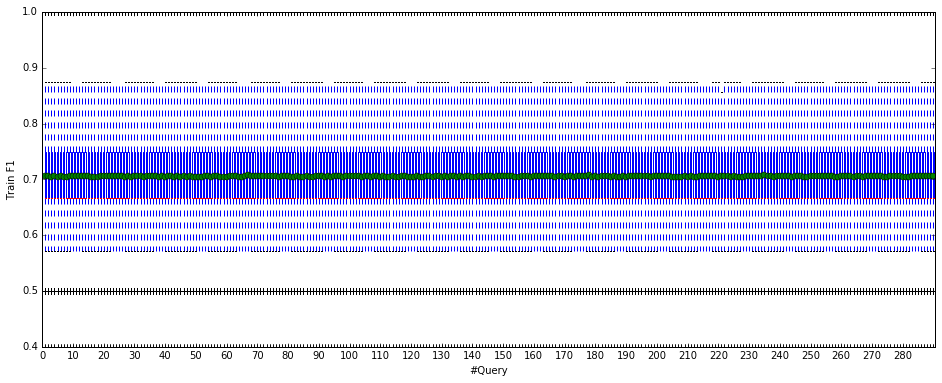

In [38]:
plt.figure(figsize=[16, 6])
plt.xlabel('#Query')
plt.ylabel('Train F1')
plt.boxplot(F1_l1o_train)
plt.plot(np.arange(1, len(F1_l1o_train)+1), [np.mean(x) for x in F1_l1o_train], color='g', marker='o')
plt.xticks(list(range(0, len(F1_l1o_train), 10)), list(range(0, len(F1_l1o_train), 10))) # xticks starts from 1

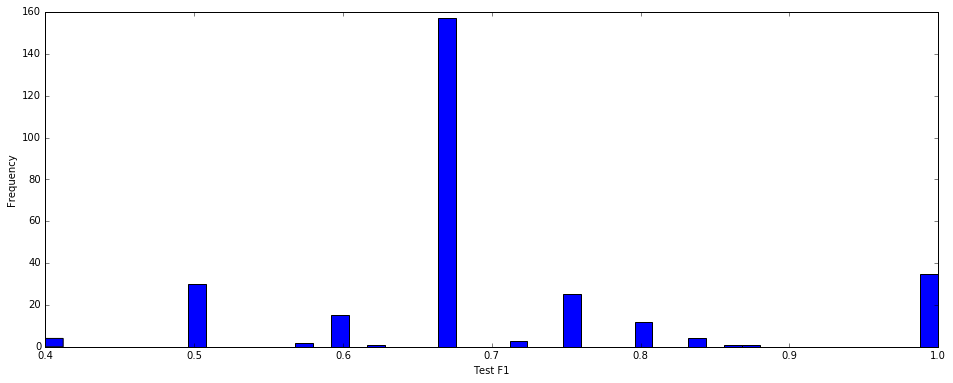

In [39]:
plt.figure(figsize=[16, 6])
plt.hist([y for x in F1_l1o_test for y in x], bins=50)
plt.xlabel('Test F1')
plt.ylabel('Frequency')

## 3.2 Random Baseline - Passive Learing

Choose a sequence to query uniformly at random, i.e. passive learning.

In [40]:
def random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, seq_stats, poi_all, query_id_dict):
    seq_idx = np.arange(len(seqid_set_query))
    np.random.shuffle(seq_idx)
    F1scores_train = []
    F1scores_test  = []
    
    cnt = 0
    while len(seqid_set_query) > 0:
        # compute features for training
        poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_data_df(seqid_set_train, seq_all, seq_stats, poi_info_train, query_id_dict)
        
        # training rankSVM
        #C = 100
        #C = 300
        #C = 1000
        C = 1e6
        ranksvm = RankSVM(ranksvm_dir)
        ranksvm.train(train_df, C)
        poi_rank_df = ranksvm.predict(train_df)
        poi_rank_df.sort_values(by='rank', ascending=True, inplace=True)
        #print(poi_rank_df)
        
        # compute training accuracy
        F1scores = evaluate(seqid_set_train, seq_all, poi_all, poi_rank_df, query_id_dict)#, debug=True)
        F1scores_train.append(F1scores)
        #print('Iteration %d, mean F1: %.2f\n' % (cnt, np.mean(F1scores)))
        
        # compute testing accuracy
        F1scores = evaluate(seqid_set_test, seq_all, poi_all, poi_rank_df, query_id_dict)
        F1scores_test.append(F1scores)
        
        # query strategy
        seq_idx = -1 # the last element after random shuffle
        seqid_set_train.append(seqid_set_query[seq_idx])
        del seqid_set_query[seq_idx]
        
        cnt += 1
        
    return F1scores_train, F1scores_test

## 3.3 Least Confident Query Strategy

Relevant Definitions
- Constraint: $\textbf{x} = (P_s, P_e, \lvert Traj \rvert)$
- Query: what is the best trajectory to recommend with respect to the above constraint?
- Result of Query: $\textbf{y} = Traj$
- Probability of Possible Trajectory: rescale the score for ranking of POIs to $[-1, 1]$, then shift 1 unit to the right. define the score of a trajectory by summing over its POIs, normalise scores over all possible trajectory to get a probability distribution.  
*Problem: NOT Good because the "number" for each POI only optimised for ranking purpose, i.e. the absolute value of the "number" for each POI is meaningless as long as "number" for visited POI is greater than "number" for unvisited POI.*

Query Strategy:
\begin{equation}
\phi^{LC}(\textbf{x}) = 1 - P(\textbf{y}^* | \textbf{x}; \Theta)
\end{equation}
where $\textbf{y}^*$ is the most likely label of example $\textbf{x}$ with respect to a probabilistic model of which the parameters are denoted by $\Theta$.  
This query strategy select the example $\textbf{x}$ of maximum $\phi^{LC}$ from all unlabelled examples in a pool to query.

This strategy is biased to long trajectories (i.e. trajectory with more POIs).

In [51]:
def calc_confidence(startPOI, endPOI, nPOI, poi_list, poi_rank_df):
    # calculate the probability of most likely possible sequence
    assert(nPOI > 2)
    
    # enumerate all possible trajectories
    enum_seqs = enum_seq(poi_list, startPOI, endPOI, nPOI) 
    
    # scoring each trajectory
    scores_traj = np.array([poi_rank_df.loc[x, 'rank'].sum() for x in enum_seqs])
    
    # normalise to get a probability distribution
    assert(np.sum(scores_traj) > 0)
    probs = scores_traj / np.sum(scores_traj)
    
    return max(probs)

In [52]:
def least_confident(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, seq_stats, poi_all, query_id_dict):
    F1scores_train = []
    F1scores_test  = []
    query_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_query]
    
    rankings = []
    
    while len(seqid_set_query) > 0:
        # compute features for training
        poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_data_df(seqid_set_train, seq_all, seq_stats, poi_info_train, query_id_dict)
        
        # training rankSVM
        #C = 100
        #C = 300
        C = 1000
        ranksvm = RankSVM(ranksvm_dir)
        ranksvm.train(train_df, C)
        poi_rank_df = ranksvm.predict(train_df)
        
        # compute training accuracy
        F1scores = evaluate(seqid_set_train, seq_all, poi_all, poi_rank_df, query_id_dict)
        F1scores_train.append(F1scores)
        
        # compute testing accuracy
        F1scores = evaluate(seqid_set_test, seq_all, poi_all, poi_rank_df, query_id_dict)
        F1scores_test.append(F1scores)
        
        # deal with unseen POIs
        # randomly put POIs that haven't seen before at the bottom of ranking
        unseen_poi = sorted(list(set(poi_all.index) - set(poi_rank_df.index)))
        np.random.shuffle(unseen_poi)  # tie breaking
        
        # special case: the same rank for all seen POIs
        if np.all(np.abs(poi_rank_df['rank'] - poi_rank_df['rank'].max()) < 1e-6):
            seen_poi = poi_rank_df.index.tolist()
            np.random.shuffle(seen_poi) # tie break
            pois = seen_poi + unseen_poi
            poi_rank_df = pd.DataFrame.from_dict({'poiID': pois, 'rank': np.zeros(len(pois), dtype=np.float)})
            poi_rank_df.set_index('poiID', inplace=True)
            poi_rank_df.loc[seen_poi, 'rank'] = 1 # scores for ranking: 1 for seen POIs, 0 for unseen POIs
        else:
            bottom_score = poi_rank_df['rank'].min()
            bottom_score = bottom_score - 2*abs(bottom_score)
            unseen_poi_df = pd.DataFrame.from_dict(\
                                {'poiID': unseen_poi, 'rank': bottom_score * np.ones(len(unseen_poi), dtype=np.float)})
            unseen_poi_df.set_index('poiID', inplace=True)
            poi_rank_df = poi_rank_df.append(unseen_poi_df)

        # (naively) convert POI scores for ranking into range [0, 2] so that 
        # a distribution of possible trajectories could be computed.
        scores = poi_rank_df['rank'].get_values()
        assert(max(np.abs(scores) > 1e-6))
        scores = scores / max(np.abs(scores))  # range [-1, 1]
        scores = scores + 1                    # range [ 0, 2]
        poi_rank_df['rank'] = scores
        
        # query strategy 
        confidence = Parallel(n_jobs=-2)\
                     (delayed(calc_confidence)(seq[0], seq[-1], len(seq), poi_all.index, poi_rank_df) \
                      for seq in query_seqs)
        seq_idx = np.argmin(confidence) # choose the sequence with least confident to query
        seqid_set_train.append(seqid_set_query[seq_idx])
        print('choose sequence:', query_seqs[seq_idx]); sys.stdout.flush()
        del seqid_set_query[seq_idx]
        del query_seqs[seq_idx]
        
    return F1scores_train, F1scores_test

## 3.4 Maximum Sequence Entropy Strategy

\begin{equation}
\phi^{SE}(\textbf{x}) = - \sum_{\hat{\textbf{y}}} P(\hat{\textbf{y}} | \textbf{x}; \Theta) 
\log(P(\hat{\textbf{y}} | \textbf{x}; \Theta))
\end{equation}
where $\hat{\textbf{y}}$ ranges over all possible labels for example $\textbf{x}$.  
**Note** that the number of possible labels grows exponentially with $|Traj|$ in $\textbf{x}$, to make computation feasible,
[Kim06](http://www.aclweb.org/anthology/N06-2018) used the $N$-best possible labels to approximate, concretely, 
define **N-best Sequence Entropy** as
\begin{equation}
\phi^{NSE}(\textbf{x}) = - \sum_{\hat{\textbf{y}} \in \mathcal{N}} P(\hat{\textbf{y}} | \textbf{x}; \Theta) 
\log(P(\hat{\textbf{y}} | \textbf{x}; \Theta))
\end{equation}
where $\mathcal{N} = \{\textbf{y}_1^*, \dots, \textbf{y}_N^*\}$ is the set of the $N$ most likely labels of example $\textbf{x}$.  
This query strategy select the example $\textbf{x}$ of maximum $\phi^{SE}$ or $\phi^{NSE}$ from all unlabelled examples in a pool to query.

In [53]:
def calc_sequence_entropy(startPOI, endPOI, nPOI, poi_list, poi_rank_df):
    # calculate the sequence entropy of all possible sequences/trajectories
    assert(nPOI > 2)
    
    # enumerate all possible trajectories
    enum_seqs = enum_seq(poi_list, startPOI, endPOI, nPOI) 
    
    # scoring each trajectory
    scores_traj = np.array([poi_rank_df.loc[x, 'rank'].sum() for x in enum_seqs])
    
    # normalise to get a probability distribution
    assert(np.sum(scores_traj) > 0)
    probs = scores_traj / np.sum(scores_traj)
    
    return -np.dot(probs, np.log2(probs))

In [54]:
def maximum_sequence_entropy(seqid_set_train, seqid_set_query, seqid_set_test, seq_all, \
                             seq_stats, poi_all, query_id_dict):
    F1scores_train = []
    F1scores_test  = []
    query_seqs = [extract_seq(seqid, seq_all) for seqid in seqid_set_query]
    
    while len(seqid_set_query) > 0:
        # compute features for training
        poi_info_train = calc_poi_info(seqid_set_train, seq_all, poi_all)
        train_df = gen_data_df(seqid_set_train, seq_all, seq_stats, poi_info_train, query_id_dict)
        
        # training rankSVM
        #C = 100
        #C = 300
        C = 1000
        ranksvm = RankSVM(ranksvm_dir)
        ranksvm.train(train_df, C)
        poi_rank_df = ranksvm.predict(train_df)
        
        # compute training accuracy
        F1scores = evaluate(seqid_set_train, seq_all, poi_all, poi_rank_df, query_id_dict)
        F1scores_train.append(F1scores)
        
        # compute testing accuracy
        F1scores = evaluate(seqid_set_test, seq_all, poi_all, poi_rank_df, query_id_dict)
        F1scores_test.append(F1scores)
        
        # deal with unseen POIs
        # randomly put POIs that haven't seen before at the bottom of ranking
        unseen_poi = sorted(list(set(poi_all.index) - set(poi_rank_df.index)))
        np.random.shuffle(unseen_poi)  # tie breaking
        
        # special case: the same rank for all seen POIs
        if np.all(np.abs(poi_rank_df['rank'] - poi_rank_df['rank'].max()) < 1e-6):
            seen_poi = poi_rank_df.index.tolist()
            np.random.shuffle(seen_poi) # tie break
            pois = seen_poi + unseen_poi
            poi_rank_df = pd.DataFrame.from_dict({'poiID': pois, 'rank': np.zeros(len(pois), dtype=np.float)})
            poi_rank_df.set_index('poiID', inplace=True)
            poi_rank_df.loc[seen_poi, 'rank'] = 1 # scores for ranking: 1 for seen POIs, 0 for unseen POIs
        else:
            bottom_score = poi_rank_df['rank'].min()
            bottom_score = bottom_score - 2*abs(bottom_score)
            unseen_poi_df = pd.DataFrame.from_dict(\
                                {'poiID': unseen_poi, 'rank': bottom_score * np.ones(len(unseen_poi), dtype=np.float)})
            unseen_poi_df.set_index('poiID', inplace=True)
            poi_rank_df = poi_rank_df.append(unseen_poi_df)

        # (naively) convert POI scores for ranking into range [0, 2] so that 
        # a distribution of possible trajectories could be computed.
        scores = poi_rank_df['rank'].get_values()
        assert(max(np.abs(scores) > 1e-6))
        scores = scores / max(np.abs(scores))  # range [-1, 1]
        scores = scores + 1                    # range [ 0, 2]
        poi_rank_df['rank'] = scores
        
        # query strategy 
        entropy = Parallel(n_jobs=-2)\
                          (delayed(calc_sequence_entropy)(seq[0], seq[-1], len(seq), poi_all.index, poi_rank_df) \
                           for seq in query_seqs)
        seq_idx = np.argmax(entropy) # choose the sequence with maximum entropy
        seqid_set_train.append(seqid_set_query[seq_idx])
        print('choose sequence:', query_seqs[seq_idx]); sys.stdout.flush()
        del seqid_set_query[seq_idx]
        del query_seqs[seq_idx]
        
    return F1scores_train, F1scores_test

# 4. Evaluation

In [45]:
def plot_evaluation_results(F1_train_list, F1_test_list):
    assert(len(F1_train_list) == len(F1_test_list))
    F1_train_mean = [np.mean(x) for x in F1_train_list]
    F1_train_median = [np.median(x) for x in F1_train_list]
    F1_test_mean = [np.mean(x) for x in F1_test_list]
    F1_test_median = [np.median(x) for x in F1_test_list]
    
    plt.figure(figsize=[15, 18])
    plt.subplot(3, 1, 1)
    plt.xlabel('#Query')
    plt.ylabel('Train F1')
    plt.ylim([0.3, 1.05])
    plt.boxplot(F1_train_list)
    plt.plot(np.arange(1, len(F1_train_list)+1), F1_train_mean, color='g', marker='o')
    xticks = [10*x for x in range(math.ceil(len(F1_train_list)/10))]
    plt.xticks(xticks, xticks) # xticks starts from 1
    
    
    plt.subplot(3, 1, 2)
    plt.xlabel('#Query')
    plt.ylabel('Test F1')
    plt.ylim([0.3, 1.05])
    plt.boxplot(F1_test_list)
    plt.plot(np.arange(1, len(F1_test_list)+1), F1_test_mean, color='g', marker='^')
    plt.xticks(xticks, xticks)
    
    plt.subplot(3, 1, 3)
    plt.xlabel('#Query')
    plt.ylabel('F1')
    plt.ylim([0.5, 0.9])
    plt.plot(np.arange(len(F1_train_list)), F1_train_mean, ls='-.', label='Train F1 - Mean')
    plt.plot(np.arange(len(F1_train_list)), F1_train_median, ls='--', label='Train F1 - Median')
    plt.plot(np.arange(len(F1_test_list)), F1_test_mean, ls='-', label='Test F1 - Mean')
    plt.plot(np.arange(len(F1_test_list)), F1_test_median, ls=':', label='Test F1 - Median')
    plt.legend(loc='lower right')

## 4.1 Evaluate Random Baseline Query Strategy

In [46]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()

In [47]:
F1_rand_train, F1_rand_test = random_baseline(seqid_set_train, seqid_set_query, seqid_set_test, \
                                              seq_all, seq_stats, poi_all, query_id_dict)

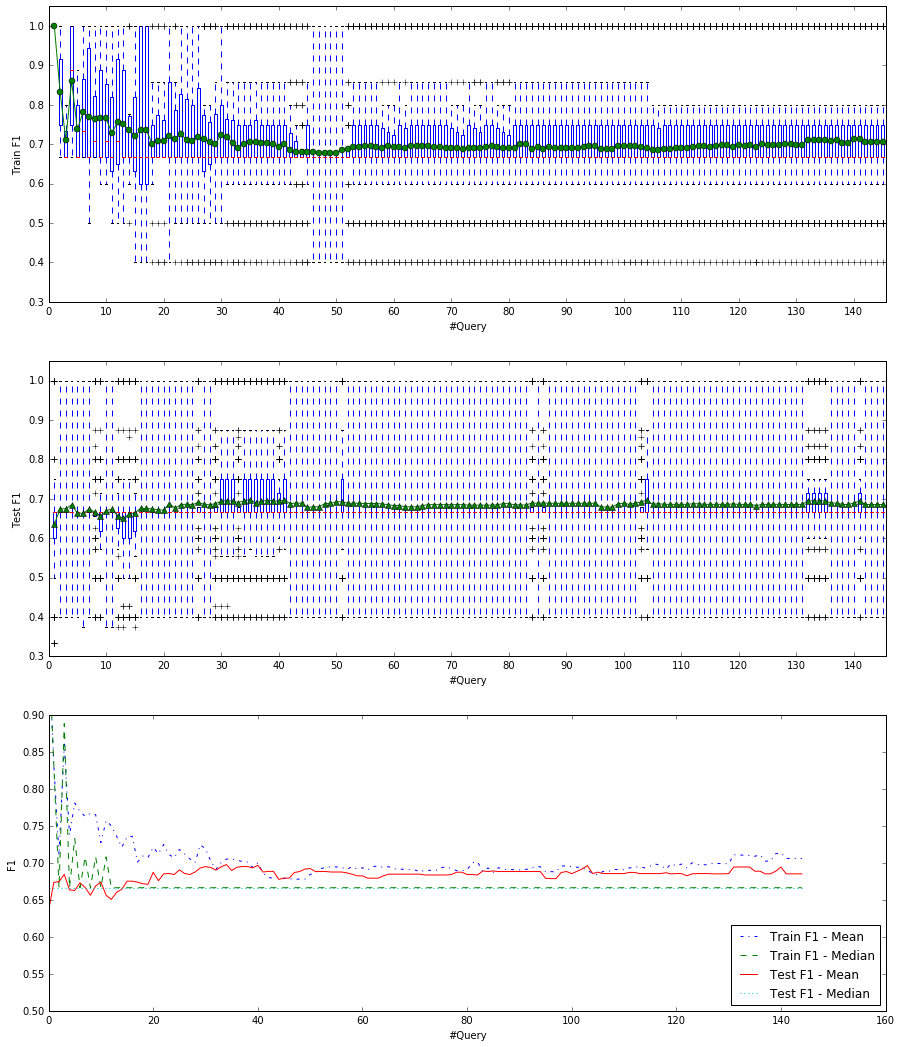

In [48]:
plot_evaluation_results(F1_rand_train, F1_rand_test)

## 4.2 Evaluate Least Confident Query Strategy

In [55]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()

In [56]:
F1_lc_train, F1_lc_test = least_confident(seqid_set_train, seqid_set_query, seqid_set_test, \
                                          seq_all, seq_stats, poi_all, query_id_dict)

choose sequence: [11, 29, 6, 22, 28, 7, 30, 1, 15]
choose sequence: [6, 22, 28, 21, 23, 30, 7]
choose sequence: [7, 23, 28, 30, 21, 22, 11]
choose sequence: [22, 30, 7, 1, 8, 16, 21]
choose sequence: [22, 28, 21, 30, 1, 8, 16]
choose sequence: [3, 21, 23, 28, 7, 30, 22]
choose sequence: [21, 22, 4, 16, 25, 11]
choose sequence: [23, 7, 30, 16, 8, 4]
choose sequence: [7, 23, 28, 21, 30]
choose sequence: [7, 30, 21, 23, 22]
choose sequence: [30, 22, 28, 29, 16]
choose sequence: [22, 21, 3, 23, 28]
choose sequence: [7, 30, 21, 23, 28]
choose sequence: [7, 30, 22, 21, 23]
choose sequence: [21, 7, 30, 16, 4]
choose sequence: [8, 22, 28, 16, 7]
choose sequence: [25, 6, 22, 21, 28]
choose sequence: [23, 30, 22, 28, 3]
choose sequence: [16, 8, 28, 22, 6]
choose sequence: [21, 23, 6, 25, 27]
choose sequence: [6, 16, 11, 4, 8]
choose sequence: [24, 16, 30, 6, 21]
choose sequence: [30, 7, 23, 21]
choose sequence: [22, 28, 23, 21]
choose sequence: [21, 23, 30, 28]
choose sequence: [7, 28, 22, 30]
c

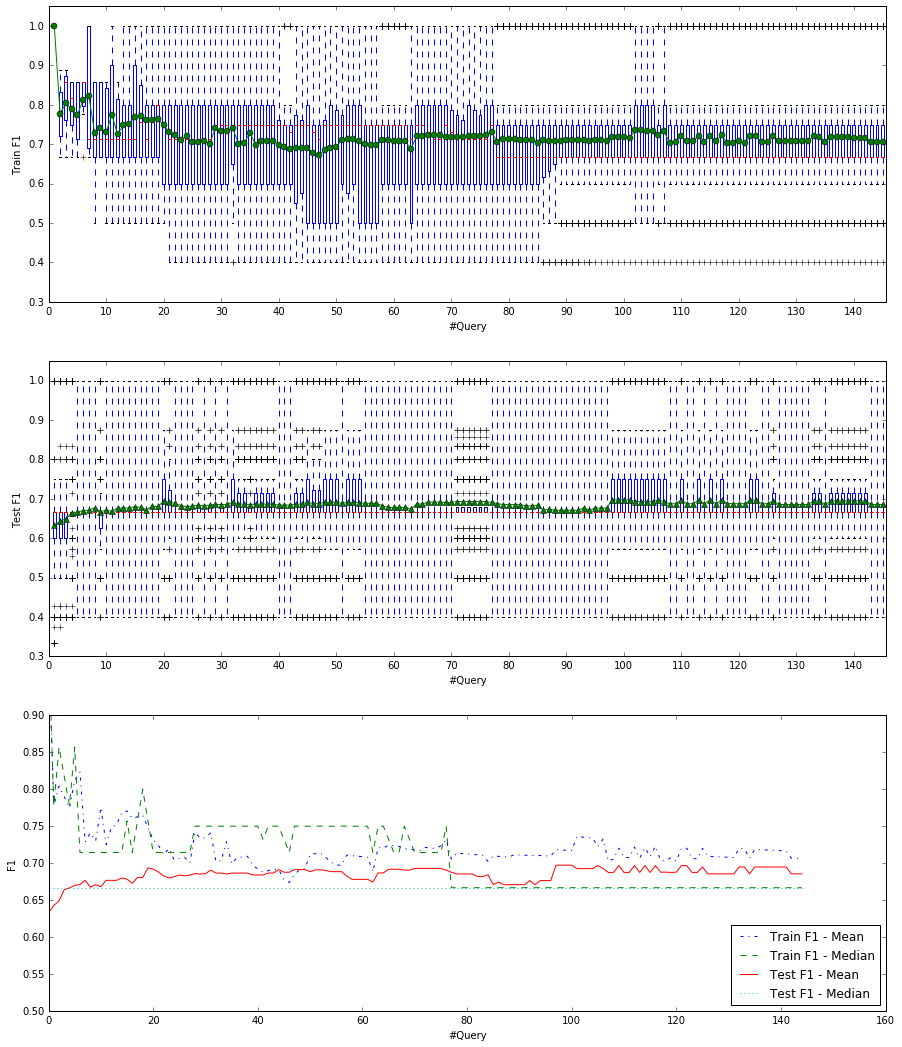

In [57]:
plot_evaluation_results(F1_lc_train, F1_lc_test)

## 4.3 Evaluate Maximum Entropy Query Strategy

In [58]:
seqid_set_train = seqid_set_train0.copy()
seqid_set_query = seqid_set_query0.copy()
seqid_set_test  = seqid_set_test0.copy()

In [59]:
F1_mse_train, F1_mse_test = maximum_sequence_entropy(seqid_set_train, seqid_set_query, seqid_set_test, \
                                                     seq_all, seq_stats, poi_all, query_id_dict)

choose sequence: [11, 29, 6, 22, 28, 7, 30, 1, 15]
choose sequence: [17, 2, 14]
choose sequence: [8, 30, 28, 23]
choose sequence: [25, 16, 24]
choose sequence: [19, 7, 23, 21]
choose sequence: [6, 22, 28, 21, 23, 30, 7]
choose sequence: [7, 23, 28, 30, 21, 22, 11]
choose sequence: [22, 30, 7, 1, 8, 16, 21]
choose sequence: [22, 28, 21, 30, 1, 8, 16]
choose sequence: [3, 21, 23, 28, 7, 30, 22]
choose sequence: [21, 22, 4, 16, 25, 11]
choose sequence: [23, 7, 30, 16, 8, 4]
choose sequence: [7, 23, 28, 21, 30]
choose sequence: [7, 30, 21, 23, 22]
choose sequence: [7, 30, 22, 21, 23]
choose sequence: [30, 22, 28, 29, 16]
choose sequence: [7, 30, 21, 23, 28]
choose sequence: [22, 21, 3, 23, 28]
choose sequence: [8, 22, 28, 16, 7]
choose sequence: [21, 7, 30, 16, 4]
choose sequence: [24, 16, 30, 6, 21]
choose sequence: [16, 8, 28, 22, 6]
choose sequence: [25, 6, 22, 21, 28]
choose sequence: [23, 30, 22, 28, 3]
choose sequence: [6, 16, 11, 4, 8]
choose sequence: [21, 23, 6, 25, 27]
choose seq

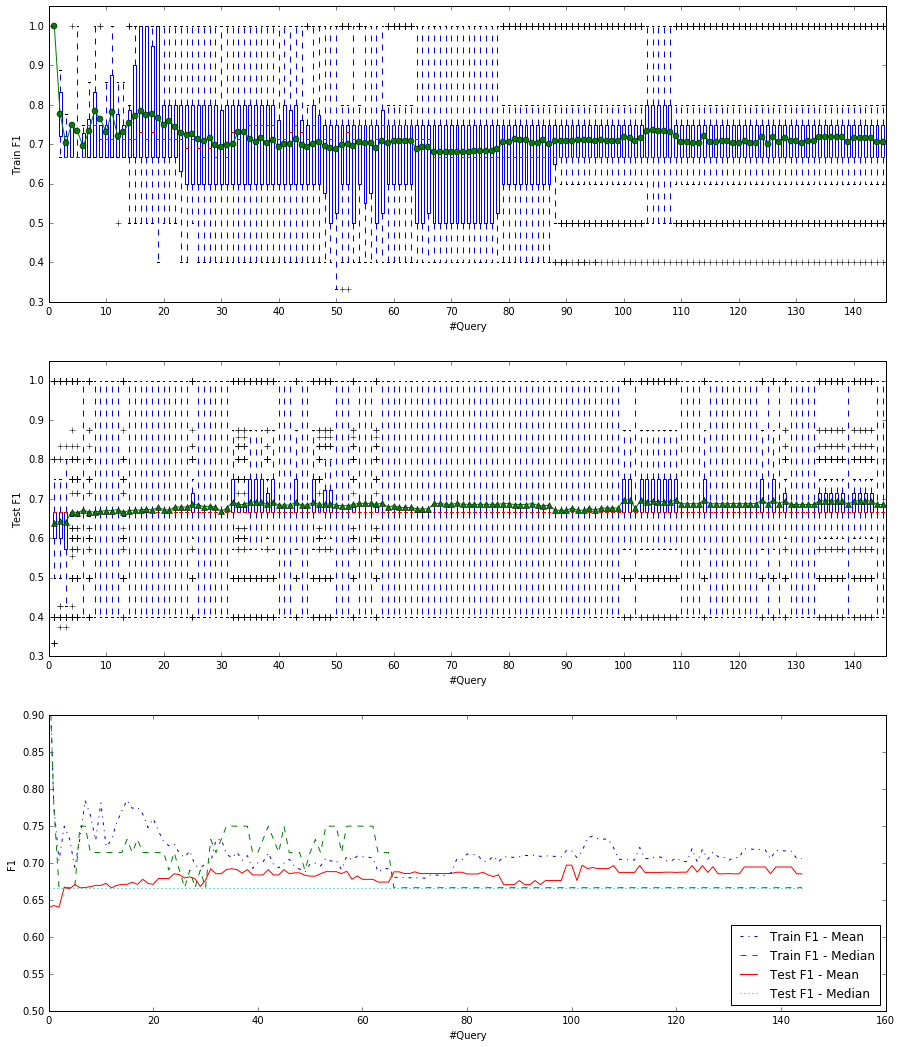

In [60]:
plot_evaluation_results(F1_mse_train, F1_mse_test)